# Autoencoders in SciKeras

Autencoders are an approach to use nearual networks to distill data into it's most important features, thereby compressing the data. We will be following the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) on the topic, which goes much more in depth and breadth than we will here. You are highly encouraged to check out that tutorial if you want to learn about autoencoders in the general sense.

## Table of contents

* [1. Setup](#1.-Setup)
* [2. Data](#2.-Data)
* [3. Define Keras Model](#3.-Define-Keras-Model)
* [4. Training](#4.-Training)
* [5. Explore Results](#5.-Explore-Results)

## 1. Setup

In [1]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

Silence TensorFlow logging to keep output succinct.

In [2]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [3]:
import numpy as np
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

## 2. Data

We load the dataset from the Keras tutorial. The dataset consists of images of cats and dogs.

In [4]:
from tensorflow.keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


## 3. Define Keras Model

We will be defining a very simple autencoder. We define _three_ model building methods:

1. One to build a full end-to-end autoencoder.
2. One to create a model that includes only the encoder portion.
3. One that creates a model that includes only the decoder portion.

The only variable we give our model is the encoding dimensions, which will be a hyperparemter of our final transformer.

In [5]:
from tensorflow import keras


def get_fit_model(encoding_dim: int) -> keras.Model:
    """Get an autoencoder.

    This autoencoder compresses a 28x28 image (784 pixels) down to a feature of length
    `encoding_dim`, and tries to reconstruct the input image from that vector.
    """
    input_img = keras.Input(shape=(784,), name="input")
    encoded = keras.layers.Dense(encoding_dim, activation='relu', name="encoded")(input_img)
    decoded = keras.layers.Dense(784, activation='sigmoid', name="output")(encoded)
    autoencoder_model = keras.Model(input_img, decoded)
    return autoencoder_model

def get_tf_model(fit_model: keras.Model) -> keras.Model:
    """Get an encoder model.

    We do this by extracting the encoding layer from the fitted autoencoder model.
    """
    return keras.Model(fit_model.get_layer("input").input, fit_model.get_layer("encoded").output)

def get_inverse_tf_model(fit_model: keras.Model, encoding_dim: int) -> keras.Model:
    """Get an deencoder model.

    We do this by extracting the deencoding layer from the fitted autoencoder model
    and adding a new Keras input layer.
    """
    encoded_input = keras.Input(shape=(encoding_dim,))
    output = fit_model.get_layer("output")(encoded_input)
    return keras.Model(encoded_input, output)

Next we create a class that that will enable the `transform` and `fit_transform` methods, as well as integrating all three of our models into a single estimator.

In [6]:
from sklearn.base import TransformerMixin, clone
from scikeras.wrappers import BaseWrapper


class KerasTransformer(BaseWrapper, TransformerMixin):
    """A class that enables transform and fit_transform.
    """

    def __init__(self, *args, tf_est: BaseWrapper = None, inv_tf_est: BaseWrapper = None, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.tf_est = tf_est
        self.inv_tf_est = inv_tf_est


    def fit(self, X, sample_weight=None):
        super().fit(X=X, y=X, sample_weight=sample_weight)
        self.tf_est_ = clone(self.tf_est)
        self.inv_tf_est_ = clone(self.inv_tf_est)
        self.tf_est_.set_params(fit_model=self.model_)
        self.inv_tf_est_.set_params(fit_model=self.model_, encoding_dim=self.encoding_dim)
        X = self.feature_encoder_.transform(X)
        self.tf_est_.initialize(X=X)
        X_tf = self.tf_est_.predict(X=X)
        self.inv_tf_est_.initialize(X_tf)
        return self

    def transform(self, X):
        X = self.feature_encoder_.transform(X)
        X_tf = self.tf_est_.predict(X)
        return X_tf
    
    def inverse_transform(self, X_tf):
        X = self.inv_tf_est_.predict(X_tf)
        X = self.feature_encoder_.inverse_transform(X)
        return X

Next, we wrap the Keras Model with Scikeras. Note that for our encoder/decoder estimators, we do not need to provide a loss function since no training will be done. We do however need to have the `fit_model` and `encoding_dim` so that these will be settable by `BaseWrapper.set_params`.

In [7]:
tf_est = BaseWrapper(model=get_tf_model, fit_model=None, verbose=0)
inv_tf_est = BaseWrapper(model=get_inverse_tf_model, fit_model=None, encoding_dim=None, verbose=0)
autoencoder = KerasTransformer(model=get_fit_model, tf_est=tf_est, inv_tf_est=inv_tf_est, loss="binary_crossentropy", encoding_dim=32, epochs=5)

## 4. Training

To train the model, we pass the input images as both the features and the target. This will train the layers to compress the data as accurately as possible between the encoder and decoder. Note that we only pass the `X` parameter, since we defined the mapping `y=X` in `KerasTransformer.fit` above.

In [8]:
_ = autoencoder.fit(X=x_train)

Epoch 1/5


   1/1875 [..............................] - ETA: 22:03 - loss: 0.6937

  26/1875 [..............................] - ETA: 3s - loss: 0.5604   

  51/1875 [..............................] - ETA: 3s - loss: 0.4820

  72/1875 [>.............................] - ETA: 3s - loss: 0.4446

  94/1875 [>.............................] - ETA: 3s - loss: 0.4180

 123/1875 [>.............................] - ETA: 3s - loss: 0.3931

 150/1875 [=>............................] - ETA: 3s - loss: 0.3759

 176/1875 [=>............................] - ETA: 3s - loss: 0.3625

 203/1875 [==>...........................] - ETA: 3s - loss: 0.3510

 230/1875 [==>...........................] - ETA: 3s - loss: 0.3410

 256/1875 [===>..........................] - ETA: 3s - loss: 0.3327

 284/1875 [===>..........................] - ETA: 3s - loss: 0.3247

 311/1875 [===>..........................] - ETA: 3s - loss: 0.3178

 339/1875 [====>.........................] - ETA: 3s - loss: 0.3113

 367/1875 [====>.........................] - ETA: 2s - loss: 0.3054

 394/1875 [=====>........................] - ETA: 2s - loss: 0.3002

 420/1875 [=====>........................] - ETA: 2s - loss: 0.2956

 447/1875 [======>.......................] - ETA: 2s - loss: 0.2911

 470/1875 [======>.......................] - ETA: 2s - loss: 0.2876

 497/1875 [======>.......................] - ETA: 2s - loss: 0.2836

 521/1875 [=======>......................] - ETA: 2s - loss: 0.2804

 547/1875 [=======>......................] - ETA: 2s - loss: 0.2770

 575/1875 [========>.....................] - ETA: 2s - loss: 0.2736

 601/1875 [========>.....................] - ETA: 2s - loss: 0.2706

 629/1875 [=========>....................] - ETA: 2s - loss: 0.2675

 656/1875 [=========>....................] - ETA: 2s - loss: 0.2647

 683/1875 [=========>....................] - ETA: 2s - loss: 0.2621

 710/1875 [==========>...................] - ETA: 2s - loss: 0.2595

 734/1875 [==========>...................] - ETA: 2s - loss: 0.2573

 761/1875 [===========>..................] - ETA: 2s - loss: 0.2550

 788/1875 [===========>..................] - ETA: 2s - loss: 0.2528

 816/1875 [============>.................] - ETA: 2s - loss: 0.2505

 838/1875 [============>.................] - ETA: 2s - loss: 0.2488

 864/1875 [============>.................] - ETA: 1s - loss: 0.2469

 892/1875 [=============>................] - ETA: 1s - loss: 0.2449

 915/1875 [=============>................] - ETA: 1s - loss: 0.2433

 942/1875 [==============>...............] - ETA: 1s - loss: 0.2415

 968/1875 [==============>...............] - ETA: 1s - loss: 0.2398

 995/1875 [==============>...............] - ETA: 1s - loss: 0.2382

1022/1875 [===============>..............] - ETA: 1s - loss: 0.2365

1049/1875 [===============>..............] - ETA: 1s - loss: 0.2349

1075/1875 [================>.............] - ETA: 1s - loss: 0.2335

1104/1875 [================>.............] - ETA: 1s - loss: 0.2319

1130/1875 [=================>............] - ETA: 1s - loss: 0.2305

1157/1875 [=================>............] - ETA: 1s - loss: 0.2291

1180/1875 [=================>............] - ETA: 1s - loss: 0.2279

1203/1875 [==================>...........] - ETA: 1s - loss: 0.2268

1231/1875 [==================>...........] - ETA: 1s - loss: 0.2254

1257/1875 [===================>..........] - ETA: 1s - loss: 0.2242

1285/1875 [===================>..........] - ETA: 1s - loss: 0.2229

1310/1875 [===================>..........] - ETA: 1s - loss: 0.2218

1338/1875 [====================>.........] - ETA: 1s - loss: 0.2206

1364/1875 [====================>.........] - ETA: 0s - loss: 0.2195

1388/1875 [=====================>........] - ETA: 0s - loss: 0.2185

1414/1875 [=====================>........] - ETA: 0s - loss: 0.2175

1436/1875 [=====================>........] - ETA: 0s - loss: 0.2166

1463/1875 [======================>.......] - ETA: 0s - loss: 0.2155

1490/1875 [======================>.......] - ETA: 0s - loss: 0.2145

1515/1875 [=======================>......] - ETA: 0s - loss: 0.2136

1543/1875 [=======================>......] - ETA: 0s - loss: 0.2126

1570/1875 [========================>.....] - ETA: 0s - loss: 0.2116

1598/1875 [========================>.....] - ETA: 0s - loss: 0.2106

1625/1875 [=========================>....] - ETA: 0s - loss: 0.2097

1652/1875 [=========================>....] - ETA: 0s - loss: 0.2088

1679/1875 [=========================>....] - ETA: 0s - loss: 0.2079

1706/1875 [==========================>...] - ETA: 0s - loss: 0.2071

1734/1875 [==========================>...] - ETA: 0s - loss: 0.2062

1761/1875 [===========================>..] - ETA: 0s - loss: 0.2054

1785/1875 [===========================>..] - ETA: 0s - loss: 0.2046

1811/1875 [===========================>..] - ETA: 0s - loss: 0.2039

1838/1875 [============================>.] - ETA: 0s - loss: 0.2031

1862/1875 [============================>.] - ETA: 0s - loss: 0.2024

1875/1875 [==============================] - 4s 2ms/step - loss: 0.2020


Epoch 2/5
   1/1875 [..............................] - ETA: 3s - loss: 0.1067

  29/1875 [..............................] - ETA: 3s - loss: 0.1099

  56/1875 [..............................] - ETA: 3s - loss: 0.1102

  83/1875 [>.............................] - ETA: 3s - loss: 0.1102

 110/1875 [>.............................] - ETA: 3s - loss: 0.1102

 137/1875 [=>............................] - ETA: 3s - loss: 0.1101

 163/1875 [=>............................] - ETA: 3s - loss: 0.1100

 190/1875 [==>...........................] - ETA: 3s - loss: 0.1099

 217/1875 [==>...........................] - ETA: 3s - loss: 0.1099

 243/1875 [==>...........................] - ETA: 3s - loss: 0.1098

 268/1875 [===>..........................] - ETA: 3s - loss: 0.1097

 289/1875 [===>..........................] - ETA: 3s - loss: 0.1096

 314/1875 [====>.........................] - ETA: 3s - loss: 0.1095

 341/1875 [====>.........................] - ETA: 2s - loss: 0.1095

 371/1875 [====>.........................] - ETA: 2s - loss: 0.1093

 398/1875 [=====>........................] - ETA: 2s - loss: 0.1093

 426/1875 [=====>........................] - ETA: 2s - loss: 0.1092

 454/1875 [======>.......................] - ETA: 2s - loss: 0.1091

 482/1875 [======>.......................] - ETA: 2s - loss: 0.1090

 505/1875 [=======>......................] - ETA: 2s - loss: 0.1089

 531/1875 [=======>......................] - ETA: 2s - loss: 0.1089

 556/1875 [=======>......................] - ETA: 2s - loss: 0.1088

 584/1875 [========>.....................] - ETA: 2s - loss: 0.1087

 612/1875 [========>.....................] - ETA: 2s - loss: 0.1086

 640/1875 [=========>....................] - ETA: 2s - loss: 0.1086

 668/1875 [=========>....................] - ETA: 2s - loss: 0.1085

 695/1875 [==========>...................] - ETA: 2s - loss: 0.1084

 724/1875 [==========>...................] - ETA: 2s - loss: 0.1083

 750/1875 [===========>..................] - ETA: 2s - loss: 0.1082

 779/1875 [===========>..................] - ETA: 2s - loss: 0.1082

 807/1875 [===========>..................] - ETA: 2s - loss: 0.1081

 836/1875 [============>.................] - ETA: 1s - loss: 0.1080

 863/1875 [============>.................] - ETA: 1s - loss: 0.1079

 891/1875 [=============>................] - ETA: 1s - loss: 0.1079

 918/1875 [=============>................] - ETA: 1s - loss: 0.1078

 946/1875 [==============>...............] - ETA: 1s - loss: 0.1077

 972/1875 [==============>...............] - ETA: 1s - loss: 0.1077

1000/1875 [===============>..............] - ETA: 1s - loss: 0.1076

1028/1875 [===============>..............] - ETA: 1s - loss: 0.1075

1053/1875 [===============>..............] - ETA: 1s - loss: 0.1075

1080/1875 [================>.............] - ETA: 1s - loss: 0.1074

1105/1875 [================>.............] - ETA: 1s - loss: 0.1074

1133/1875 [=================>............] - ETA: 1s - loss: 0.1073

1159/1875 [=================>............] - ETA: 1s - loss: 0.1073

1187/1875 [=================>............] - ETA: 1s - loss: 0.1072

1213/1875 [==================>...........] - ETA: 1s - loss: 0.1071

1239/1875 [==================>...........] - ETA: 1s - loss: 0.1071

1267/1875 [===================>..........] - ETA: 1s - loss: 0.1070

1290/1875 [===================>..........] - ETA: 1s - loss: 0.1070

1313/1875 [====================>.........] - ETA: 1s - loss: 0.1069

1336/1875 [====================>.........] - ETA: 1s - loss: 0.1069

1363/1875 [====================>.........] - ETA: 0s - loss: 0.1068

1389/1875 [=====================>........] - ETA: 0s - loss: 0.1068

1414/1875 [=====================>........] - ETA: 0s - loss: 0.1067

1438/1875 [======================>.......] - ETA: 0s - loss: 0.1067

1466/1875 [======================>.......] - ETA: 0s - loss: 0.1066

1488/1875 [======================>.......] - ETA: 0s - loss: 0.1066

1510/1875 [=======================>......] - ETA: 0s - loss: 0.1065

1529/1875 [=======================>......] - ETA: 0s - loss: 0.1065

1555/1875 [=======================>......] - ETA: 0s - loss: 0.1064

1581/1875 [========================>.....] - ETA: 0s - loss: 0.1064

1607/1875 [========================>.....] - ETA: 0s - loss: 0.1063

1630/1875 [=========================>....] - ETA: 0s - loss: 0.1063

1652/1875 [=========================>....] - ETA: 0s - loss: 0.1062

1677/1875 [=========================>....] - ETA: 0s - loss: 0.1062

1704/1875 [==========================>...] - ETA: 0s - loss: 0.1061

1732/1875 [==========================>...] - ETA: 0s - loss: 0.1061

1752/1875 [===========================>..] - ETA: 0s - loss: 0.1061

1781/1875 [===========================>..] - ETA: 0s - loss: 0.1060

1809/1875 [===========================>..] - ETA: 0s - loss: 0.1059

1838/1875 [============================>.] - ETA: 0s - loss: 0.1059

1865/1875 [============================>.] - ETA: 0s - loss: 0.1058

1875/1875 [==============================] - 4s 2ms/step - loss: 0.1058


Epoch 3/5
   1/1875 [..............................] - ETA: 4s - loss: 0.0927

  30/1875 [..............................] - ETA: 3s - loss: 0.0968

  58/1875 [..............................] - ETA: 3s - loss: 0.0975

  81/1875 [>.............................] - ETA: 3s - loss: 0.0975

 101/1875 [>.............................] - ETA: 3s - loss: 0.0975

 126/1875 [=>............................] - ETA: 3s - loss: 0.0976

 153/1875 [=>............................] - ETA: 3s - loss: 0.0976

 180/1875 [=>............................] - ETA: 3s - loss: 0.0976

 207/1875 [==>...........................] - ETA: 3s - loss: 0.0976

 235/1875 [==>...........................] - ETA: 3s - loss: 0.0977

 261/1875 [===>..........................] - ETA: 3s - loss: 0.0976

 285/1875 [===>..........................] - ETA: 3s - loss: 0.0976

 312/1875 [===>..........................] - ETA: 3s - loss: 0.0976

 340/1875 [====>.........................] - ETA: 2s - loss: 0.0976

 367/1875 [====>.........................] - ETA: 2s - loss: 0.0976

 392/1875 [=====>........................] - ETA: 2s - loss: 0.0976

 420/1875 [=====>........................] - ETA: 2s - loss: 0.0977

 447/1875 [======>.......................] - ETA: 2s - loss: 0.0977

 475/1875 [======>.......................] - ETA: 2s - loss: 0.0977

 502/1875 [=======>......................] - ETA: 2s - loss: 0.0977

 530/1875 [=======>......................] - ETA: 2s - loss: 0.0977

 545/1875 [=======>......................] - ETA: 2s - loss: 0.0977

 566/1875 [========>.....................] - ETA: 2s - loss: 0.0977

 590/1875 [========>.....................] - ETA: 2s - loss: 0.0977

 615/1875 [========>.....................] - ETA: 2s - loss: 0.0977

 639/1875 [=========>....................] - ETA: 2s - loss: 0.0977

 664/1875 [=========>....................] - ETA: 2s - loss: 0.0977

 691/1875 [==========>...................] - ETA: 2s - loss: 0.0977

 717/1875 [==========>...................] - ETA: 2s - loss: 0.0977

 744/1875 [==========>...................] - ETA: 2s - loss: 0.0977

 770/1875 [===========>..................] - ETA: 2s - loss: 0.0977

 797/1875 [===========>..................] - ETA: 2s - loss: 0.0977

 824/1875 [============>.................] - ETA: 2s - loss: 0.0977

 850/1875 [============>.................] - ETA: 2s - loss: 0.0977

 873/1875 [============>.................] - ETA: 1s - loss: 0.0977

 892/1875 [=============>................] - ETA: 1s - loss: 0.0977

 911/1875 [=============>................] - ETA: 1s - loss: 0.0977

 932/1875 [=============>................] - ETA: 1s - loss: 0.0976

 951/1875 [==============>...............] - ETA: 1s - loss: 0.0976

 973/1875 [==============>...............] - ETA: 1s - loss: 0.0976

1001/1875 [===============>..............] - ETA: 1s - loss: 0.0976

1030/1875 [===============>..............] - ETA: 1s - loss: 0.0976

1052/1875 [===============>..............] - ETA: 1s - loss: 0.0976

1082/1875 [================>.............] - ETA: 1s - loss: 0.0976

1100/1875 [================>.............] - ETA: 1s - loss: 0.0976

1121/1875 [================>.............] - ETA: 1s - loss: 0.0976

1141/1875 [=================>............] - ETA: 1s - loss: 0.0976

1162/1875 [=================>............] - ETA: 1s - loss: 0.0976

1187/1875 [=================>............] - ETA: 1s - loss: 0.0976

1210/1875 [==================>...........] - ETA: 1s - loss: 0.0976

1239/1875 [==================>...........] - ETA: 1s - loss: 0.0976

1267/1875 [===================>..........] - ETA: 1s - loss: 0.0976

1290/1875 [===================>..........] - ETA: 1s - loss: 0.0976

1311/1875 [===================>..........] - ETA: 1s - loss: 0.0976

1336/1875 [====================>.........] - ETA: 1s - loss: 0.0976

1354/1875 [====================>.........] - ETA: 1s - loss: 0.0976

1380/1875 [=====================>........] - ETA: 1s - loss: 0.0976

1401/1875 [=====================>........] - ETA: 0s - loss: 0.0976

1427/1875 [=====================>........] - ETA: 0s - loss: 0.0976

1450/1875 [======================>.......] - ETA: 0s - loss: 0.0976

1472/1875 [======================>.......] - ETA: 0s - loss: 0.0976

1490/1875 [======================>.......] - ETA: 0s - loss: 0.0975

1512/1875 [=======================>......] - ETA: 0s - loss: 0.0975

1534/1875 [=======================>......] - ETA: 0s - loss: 0.0975

1551/1875 [=======================>......] - ETA: 0s - loss: 0.0975

1575/1875 [========================>.....] - ETA: 0s - loss: 0.0975

1599/1875 [========================>.....] - ETA: 0s - loss: 0.0975

1621/1875 [========================>.....] - ETA: 0s - loss: 0.0975

1648/1875 [=========================>....] - ETA: 0s - loss: 0.0975

1675/1875 [=========================>....] - ETA: 0s - loss: 0.0975

1703/1875 [==========================>...] - ETA: 0s - loss: 0.0975

1729/1875 [==========================>...] - ETA: 0s - loss: 0.0975

1758/1875 [===========================>..] - ETA: 0s - loss: 0.0975

1786/1875 [===========================>..] - ETA: 0s - loss: 0.0975

1815/1875 [============================>.] - ETA: 0s - loss: 0.0975

1841/1875 [============================>.] - ETA: 0s - loss: 0.0975

1862/1875 [============================>.] - ETA: 0s - loss: 0.0975

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0974


Epoch 4/5
   1/1875 [..............................] - ETA: 3s - loss: 0.1070



  30/1875 [..............................] - ETA: 3s - loss: 0.0970

  55/1875 [..............................] - ETA: 3s - loss: 0.0965

  80/1875 [>.............................] - ETA: 3s - loss: 0.0965

 106/1875 [>.............................] - ETA: 3s - loss: 0.0965

 126/1875 [=>............................] - ETA: 3s - loss: 0.0964

 151/1875 [=>............................] - ETA: 3s - loss: 0.0964

 177/1875 [=>............................] - ETA: 3s - loss: 0.0964

 200/1875 [==>...........................] - ETA: 3s - loss: 0.0963

 227/1875 [==>...........................] - ETA: 3s - loss: 0.0963

 255/1875 [===>..........................] - ETA: 3s - loss: 0.0963

 282/1875 [===>..........................] - ETA: 3s - loss: 0.0962

 310/1875 [===>..........................] - ETA: 3s - loss: 0.0962

 339/1875 [====>.........................] - ETA: 3s - loss: 0.0962

 360/1875 [====>.........................] - ETA: 3s - loss: 0.0962

 380/1875 [=====>........................] - ETA: 3s - loss: 0.0962

 403/1875 [=====>........................] - ETA: 3s - loss: 0.0963

 425/1875 [=====>........................] - ETA: 2s - loss: 0.0963

 452/1875 [======>.......................] - ETA: 2s - loss: 0.0963

 472/1875 [======>.......................] - ETA: 2s - loss: 0.0962

 495/1875 [======>.......................] - ETA: 2s - loss: 0.0962

 517/1875 [=======>......................] - ETA: 2s - loss: 0.0962

 543/1875 [=======>......................] - ETA: 2s - loss: 0.0962

 566/1875 [========>.....................] - ETA: 2s - loss: 0.0962

 581/1875 [========>.....................] - ETA: 2s - loss: 0.0962

 602/1875 [========>.....................] - ETA: 2s - loss: 0.0962

 623/1875 [========>.....................] - ETA: 2s - loss: 0.0962

 648/1875 [=========>....................] - ETA: 2s - loss: 0.0962

 673/1875 [=========>....................] - ETA: 2s - loss: 0.0962

 699/1875 [==========>...................] - ETA: 2s - loss: 0.0962

 723/1875 [==========>...................] - ETA: 2s - loss: 0.0962

 741/1875 [==========>...................] - ETA: 2s - loss: 0.0962

 763/1875 [===========>..................] - ETA: 2s - loss: 0.0962

 776/1875 [===========>..................] - ETA: 2s - loss: 0.0962

 797/1875 [===========>..................] - ETA: 2s - loss: 0.0962

 814/1875 [============>.................] - ETA: 2s - loss: 0.0961

 831/1875 [============>.................] - ETA: 2s - loss: 0.0961

 848/1875 [============>.................] - ETA: 2s - loss: 0.0961

 867/1875 [============>.................] - ETA: 2s - loss: 0.0961

 887/1875 [=============>................] - ETA: 2s - loss: 0.0961

 907/1875 [=============>................] - ETA: 2s - loss: 0.0961

 933/1875 [=============>................] - ETA: 2s - loss: 0.0961

 960/1875 [==============>...............] - ETA: 2s - loss: 0.0961

 986/1875 [==============>...............] - ETA: 2s - loss: 0.0961

1014/1875 [===============>..............] - ETA: 1s - loss: 0.0961

1031/1875 [===============>..............] - ETA: 1s - loss: 0.0961

1055/1875 [===============>..............] - ETA: 1s - loss: 0.0961

1076/1875 [================>.............] - ETA: 1s - loss: 0.0961

1099/1875 [================>.............] - ETA: 1s - loss: 0.0961

1126/1875 [=================>............] - ETA: 1s - loss: 0.0961

1154/1875 [=================>............] - ETA: 1s - loss: 0.0961

1173/1875 [=================>............] - ETA: 1s - loss: 0.0961

1196/1875 [==================>...........] - ETA: 1s - loss: 0.0961

1222/1875 [==================>...........] - ETA: 1s - loss: 0.0961

1247/1875 [==================>...........] - ETA: 1s - loss: 0.0961

1271/1875 [===================>..........] - ETA: 1s - loss: 0.0961

1294/1875 [===================>..........] - ETA: 1s - loss: 0.0960

1321/1875 [====================>.........] - ETA: 1s - loss: 0.0960

1344/1875 [====================>.........] - ETA: 1s - loss: 0.0960

1371/1875 [====================>.........] - ETA: 1s - loss: 0.0960

1396/1875 [=====================>........] - ETA: 1s - loss: 0.0960

1413/1875 [=====================>........] - ETA: 1s - loss: 0.0960

1441/1875 [======================>.......] - ETA: 0s - loss: 0.0960

1467/1875 [======================>.......] - ETA: 0s - loss: 0.0960

1483/1875 [======================>.......] - ETA: 0s - loss: 0.0960

1507/1875 [=======================>......] - ETA: 0s - loss: 0.0960

1533/1875 [=======================>......] - ETA: 0s - loss: 0.0960

1555/1875 [=======================>......] - ETA: 0s - loss: 0.0960

1582/1875 [========================>.....] - ETA: 0s - loss: 0.0960

1603/1875 [========================>.....] - ETA: 0s - loss: 0.0960

1625/1875 [=========================>....] - ETA: 0s - loss: 0.0960

1649/1875 [=========================>....] - ETA: 0s - loss: 0.0960

1673/1875 [=========================>....] - ETA: 0s - loss: 0.0960

1700/1875 [==========================>...] - ETA: 0s - loss: 0.0960

1725/1875 [==========================>...] - ETA: 0s - loss: 0.0960

1751/1875 [===========================>..] - ETA: 0s - loss: 0.0960

1773/1875 [===========================>..] - ETA: 0s - loss: 0.0959

1797/1875 [===========================>..] - ETA: 0s - loss: 0.0959

1823/1875 [============================>.] - ETA: 0s - loss: 0.0959

1849/1875 [============================>.] - ETA: 0s - loss: 0.0959

1867/1875 [============================>.] - ETA: 0s - loss: 0.0959

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0959


Epoch 5/5
   1/1875 [..............................] - ETA: 3s - loss: 0.0885

  26/1875 [..............................] - ETA: 3s - loss: 0.0954

  52/1875 [..............................] - ETA: 3s - loss: 0.0952

  79/1875 [>.............................] - ETA: 3s - loss: 0.0953

 105/1875 [>.............................] - ETA: 3s - loss: 0.0953

 131/1875 [=>............................] - ETA: 3s - loss: 0.0954

 152/1875 [=>............................] - ETA: 3s - loss: 0.0954

 178/1875 [=>............................] - ETA: 3s - loss: 0.0954

 205/1875 [==>...........................] - ETA: 3s - loss: 0.0954

 233/1875 [==>...........................] - ETA: 3s - loss: 0.0954

 259/1875 [===>..........................] - ETA: 3s - loss: 0.0955

 287/1875 [===>..........................] - ETA: 3s - loss: 0.0955

 315/1875 [====>.........................] - ETA: 3s - loss: 0.0955

 342/1875 [====>.........................] - ETA: 2s - loss: 0.0955

 367/1875 [====>.........................] - ETA: 2s - loss: 0.0955

 394/1875 [=====>........................] - ETA: 2s - loss: 0.0955

 418/1875 [=====>........................] - ETA: 2s - loss: 0.0955

 444/1875 [======>.......................] - ETA: 2s - loss: 0.0955

 472/1875 [======>.......................] - ETA: 2s - loss: 0.0955

 499/1875 [======>.......................] - ETA: 2s - loss: 0.0955

 526/1875 [=======>......................] - ETA: 2s - loss: 0.0955

 550/1875 [=======>......................] - ETA: 2s - loss: 0.0955

 578/1875 [========>.....................] - ETA: 2s - loss: 0.0955

 606/1875 [========>.....................] - ETA: 2s - loss: 0.0955

 626/1875 [=========>....................] - ETA: 2s - loss: 0.0955

 654/1875 [=========>....................] - ETA: 2s - loss: 0.0954

 678/1875 [=========>....................] - ETA: 2s - loss: 0.0954

 706/1875 [==========>...................] - ETA: 2s - loss: 0.0954

 734/1875 [==========>...................] - ETA: 2s - loss: 0.0954

 759/1875 [===========>..................] - ETA: 2s - loss: 0.0954

 783/1875 [===========>..................] - ETA: 2s - loss: 0.0954

 808/1875 [===========>..................] - ETA: 2s - loss: 0.0954

 833/1875 [============>.................] - ETA: 2s - loss: 0.0954

 856/1875 [============>.................] - ETA: 2s - loss: 0.0954

 883/1875 [=============>................] - ETA: 1s - loss: 0.0954

 907/1875 [=============>................] - ETA: 1s - loss: 0.0954

 932/1875 [=============>................] - ETA: 1s - loss: 0.0954

 955/1875 [==============>...............] - ETA: 1s - loss: 0.0954

 980/1875 [==============>...............] - ETA: 1s - loss: 0.0953

1006/1875 [===============>..............] - ETA: 1s - loss: 0.0953

1034/1875 [===============>..............] - ETA: 1s - loss: 0.0953

1062/1875 [===============>..............] - ETA: 1s - loss: 0.0953

1090/1875 [================>.............] - ETA: 1s - loss: 0.0953

1117/1875 [================>.............] - ETA: 1s - loss: 0.0953

1144/1875 [=================>............] - ETA: 1s - loss: 0.0953

1171/1875 [=================>............] - ETA: 1s - loss: 0.0953

1199/1875 [==================>...........] - ETA: 1s - loss: 0.0953

1220/1875 [==================>...........] - ETA: 1s - loss: 0.0953

1246/1875 [==================>...........] - ETA: 1s - loss: 0.0953

1272/1875 [===================>..........] - ETA: 1s - loss: 0.0953

1299/1875 [===================>..........] - ETA: 1s - loss: 0.0953

1324/1875 [====================>.........] - ETA: 1s - loss: 0.0953

1349/1875 [====================>.........] - ETA: 1s - loss: 0.0953

1375/1875 [=====================>........] - ETA: 0s - loss: 0.0953

1402/1875 [=====================>........] - ETA: 0s - loss: 0.0953

1429/1875 [=====================>........] - ETA: 0s - loss: 0.0952

1451/1875 [======================>.......] - ETA: 0s - loss: 0.0952

1469/1875 [======================>.......] - ETA: 0s - loss: 0.0952

1492/1875 [======================>.......] - ETA: 0s - loss: 0.0952

1519/1875 [=======================>......] - ETA: 0s - loss: 0.0952

1541/1875 [=======================>......] - ETA: 0s - loss: 0.0952

1564/1875 [========================>.....] - ETA: 0s - loss: 0.0952

1587/1875 [========================>.....] - ETA: 0s - loss: 0.0952

1613/1875 [========================>.....] - ETA: 0s - loss: 0.0952

1638/1875 [=========================>....] - ETA: 0s - loss: 0.0952

1664/1875 [=========================>....] - ETA: 0s - loss: 0.0952

1691/1875 [==========================>...] - ETA: 0s - loss: 0.0952

1715/1875 [==========================>...] - ETA: 0s - loss: 0.0952

1742/1875 [==========================>...] - ETA: 0s - loss: 0.0952

1768/1875 [===========================>..] - ETA: 0s - loss: 0.0952

1795/1875 [===========================>..] - ETA: 0s - loss: 0.0952

1821/1875 [============================>.] - ETA: 0s - loss: 0.0952

1848/1875 [============================>.] - ETA: 0s - loss: 0.0952

1875/1875 [==============================] - ETA: 0s - loss: 0.0952

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0952


Next, we round trip the test dataset and explore the performance of the autoencoder.

In [9]:
roundtrip_imgs = autoencoder.inverse_transform(autoencoder.transform(x_test))

## 5. Explore Results

Let's compare our inputs to lossy decoded outputs:

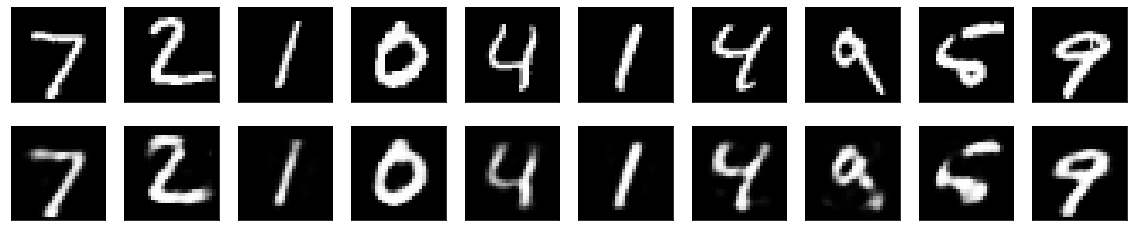

In [10]:
import matplotlib.pyplot as plt


n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(roundtrip_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

What about the compression? Let's check the sizes of the arrays.

In [11]:
encoded_imgs = autoencoder.transform(x_test)
print(f"x_test.shape[1]: {x_test.shape[1]}")
print(f"encoded_imgs.shape[1]: {encoded_imgs.shape[1]}")
cr = round((encoded_imgs.nbytes/x_test.nbytes), 2)
print(f"Compression ratio: 1/{1/cr:.0f}")

x_test.shape[1]: 784
encoded_imgs.shape[1]: 32
Compression ratio: 1/25
